In [1]:
# Third-party
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from astropy.constants import G
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
# plt.style.use('notebook.mplstyle')
plt.style.use('apw-notebook')
%matplotlib inline
import corner
import emcee
from scipy.integrate import quad
from scipy.misc import logsumexp
import schwimmbad
import tqdm

In [3]:
tgas = Table.read('../data/tgas.csv')
tgas['hd_id'] = ['240430', '240429']

# From John Brewer:
tgas['rv'] = -21.2 # km/s
tgas['rv_error'] = 0.1 # km/s

# Test a: move star 2 at fixed 3d velocity
# new_parallax = 2.
# tgas[1]['pmra'] = (tgas[1]['pmra']/tgas[1]['parallax']) * new_parallax
# tgas[1]['pmdec']  = (tgas[1]['pmdec']/tgas[1]['parallax']) * new_parallax
# tgas[1]['parallax'] = new_parallax # make them separated by 100s of pc
# tgas[1]['parallax_error'] = 0.05

# Test b: keep stars near each other, resample velocity of star 2
# tgas[1]['pmra'] = np.random.normal(0, 25) * tgas[1]['parallax']/4.74
# tgas[1]['pmdec'] = np.random.normal(0, 25) * tgas[1]['parallax']/4.74
# tgas[1]['rv'] = np.random.normal(0, 25)

In [4]:
def get_y_hat(row, names=['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'ra'], units=None):
    y = np.zeros(len(names))
        
    default_units = dict()
    default_units['ra'] = u.degree
    default_units['dec'] = u.degree
    default_units['parallax'] = u.mas
    default_units['pmra'] = u.mas/u.yr
    default_units['pmdec'] = u.mas/u.yr
    default_units['rv'] = u.km/u.s
    
    if units is None:
        units = [default_units[name] for name in names]
    
    for i,name in enumerate(names):
        y[i] = (row[name]*default_units[name]).to(units[i]).value
    
    return y

In [5]:
def get_cov(row, names=['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'ra'], units=None):
    
    default_err_units = dict()
    default_err_units['ra'] = u.mas
    default_err_units['dec'] = u.mas
    default_err_units['parallax'] = u.mas
    default_err_units['pmra'] = u.mas/u.yr
    default_err_units['pmdec'] = u.mas/u.yr
    default_err_units['rv'] = u.km/u.s
    
    if units is None:
        units = [default_err_units[name] for name in names]
    
    C = np.zeros((len(names), len(names)))

    # pre-load the diagonal
    for i,name in enumerate(names):
        full_name = "{}_error".format(name)
        C[i,i] = (row[full_name]*default_err_units[name]).to(units[i]).value**2

    for i,name1 in enumerate(names):
        for j,name2 in enumerate(names):
            if j <= i:
                continue
                
            if full_name not in row: # skip if no correlations exist
                continue
                
            full_name = "{}_{}_corr".format(name1, name2)
            u_old = default_err_units[name1]*default_err_units[name2]
            u_new = units[i]*units[j]
            C[i,j] = (row[full_name] * np.sqrt(C[i,i]*C[j,j]) * u_old).to(u_new).value
            C[j,i] = (row[full_name] * np.sqrt(C[i,i]*C[j,j]) * u_old).to(u_new).value
            
    return C

In [6]:
class ProbModel(object):
        
    def ln_posterior(self, pars):
        """ 
        Up to a normalization constant, the log of the posterior pdf is just 
        the sum of the log likelihood plus the log prior.
        """
        lnp = self.ln_prior(pars)
        if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
            return lnp

        lnL = self.ln_likelihood(pars).sum()
        lnprob = lnp + lnL

        if np.isnan(lnprob):
            return -np.inf

        return lnprob
    
    def __call__(self, pars):
        return self.ln_posterior(pars)

### Component 1: wide binary

The stars are a wide binary, drawn from the separation distribution 
$$
p(\Delta x) \propto (\Delta x)^{-1} \quad ; \quad 10^{-4}<\Delta x<10~{\rm pc}
$$

### Component 2: co-moving pair

The stars are co-moving but not necessarily *bound*

### Component 3: chance alignment

The stars are individually drawn from the field population

---

In [7]:
kmspc_to_masyr = 210.94953
masyr_to_kmspc = 1/kmspc_to_masyr

In [8]:
def xv_to_y(x, v):
    dist = np.linalg.norm(x)
    y = np.array([np.arctan2(x[1], x[0]) % (2*np.pi), # rad
                  np.arcsin(x[2] / dist), # rad
                  1000. / dist, # mas
                  v[0] / dist * kmspc_to_masyr, # mas/yr
                  v[1] / dist * kmspc_to_masyr, # mas/yr
                  v[2]]) # km/s
    return y

In [35]:
class MixtureModel(ProbModel):
    
    def __init__(self, tgas_rows, mass=[1., 1.]*u.Msun, mass_err=[0.01,0.01]*u.Msun,
                 sigma_v=25.*u.km/u.s): 
        """
        TODO: the right thing to do is to rotate (vra,vdec,vr) to (vx,vy,vz), but
            this is ok at the ~10 m/s level (given their small sky separation)
            
        TODO: update masses
        """ 
        assert len(tgas_rows) == 2
        
        self.y_hats = []
        self.Covs = []
        self.Cinvs = []
        self._uvecs = []
        self._logdets = []
        
        for row in tgas_rows:
            y_hat = get_y_hat(row, names=['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'rv'],
                              units=[u.rad, u.rad, u.mas, u.mas/u.yr, u.mas/u.yr, u.km/u.s])
            Cov = get_cov(row, names=['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'rv'],
                          units=[u.rad, u.rad, u.mas, u.mas/u.yr, u.mas/u.yr, u.km/u.s])
            _,log_det = np.linalg.slogdet(2*np.pi*Cov)
            
            rep = coord.UnitSphericalRepresentation(lon=row['ra']*u.deg, 
                                                    lat=row['dec']*u.deg)
            uvec = rep.represent_as(coord.CartesianRepresentation).xyz.value
            
            
            self.y_hats.append(y_hat)
            self.Covs.append(Cov)
            self.Cinvs.append(np.linalg.inv(Cov))
            self._uvecs.append(uvec)
            self._logdets.append(log_det)
        
        # masses
        self.mass = mass.to(u.Msun).value
        self.mass_err = mass_err.to(u.Msun).value
        self._tot_mass = np.sum(self.mass)
        self._Mred = np.prod(self.mass) / self._tot_mass # reduced mass
        
        # sky separation
        coords = coord.SkyCoord(ra=tgas_rows['ra']*u.deg, 
                                dec=tgas_rows['dec']*u.deg)
        self._cos_sep = np.cos(coords[1].separation(coords[0]))
                
        # some assumed parameters
        self._G = G.to(u.pc/u.Msun*u.km**2/u.s**2).value
        self.sigma_v = sigma_v.to(u.km/u.s).value
    
    # ======
    # Priors
    # ======
    def ln_p_lndx(self, lndx, lnmin=np.log(1E-4), lnmax=np.log(1E1)): # units are pc
        if lndx < lnmin or lndx > lnmax:
            return -np.inf
        return -np.log(lnmax-lnmin)
    
    def ln_p_x(self, x, x_max=1000., x_min=-1000.):
        if np.any(x < x_min) or np.any(x > x_max):
            return -np.inf
        return -len(x) * np.log(x_max-x_min)
    
    def unpack_pars(self, pars):
        """
        We sample over the 6D Cartesian phase-space parameters of the barycenter
        of the pair and the separation from star1 to star2 -- that is, the 
        separation is defined as positive from star1 to star2. 
        
        Positions are in [pc]
        Velocities in [km/s]
        Masses in [Msun]
        """
        (x, y, z, vx, vy, vz, # barycenter parameters
         dx, dy, dz, dvx, dvy, dvz, # separation parameters
         M1, M2, # masses
         f1, f2) = pars
        
        # construct 6D vectors of phase-space coordinates
        w_bary = np.array([x, y, z, vx, vy, vz])
        dw = np.array([dx, dy, dz, dvx, dvy, dvz])
        
        # mass ratio factors
        fac1 = self._Mred / self.mass[0]
        fac2 = self._Mred / self.mass[1]
        
        # position, velocity of star 1, star2:
        w1 = w_bary - fac1*dw
        w2 = w_bary + fac2*dw
        
        mix_weights = [f1, f2, 1-(f1+f2)]
        
        return w_bary, dw, w1, w2, [M1, M2], mix_weights
    
    def ln_component1(self, w_bary, dw, x1, v1, x2, v2):
        """
        Compute the log-likelihood for component 1 of the mixture model:
        wide binary

        - For case (1) the only parameters that matter are |∆x| and the
        direction of ∆v (assuming circular orbit), so I use the wide-binary
        separation distribution on |∆x| and assume isotropic in direction of
        ∆v (so here |∆v| is unconstrained / ignored, but we infer the
        direction?).
        """
        
        a_x = np.linalg.norm(dw[:3])
        a_v = 2*np.sqrt(self._G * self._tot_mass / a_x) # km/s
        
        # velocity separation set by separation and masses
        dv = a_v * dw[3:] / np.linalg.norm(dw[3:])
        fac1 = self._Mred / self.mass[0]
        fac2 = self._Mred / self.mass[0]
        v1 = w_bary[3:] - fac1*dv
        v2 = w_bary[3:] + fac2*dv
                
        # prior terms
        ln_p = 0.
        ln_p += self.ln_p_lndx(a_x) # TODO: is this a switch to spherical? might be improper..
        ln_p += self.ln_p_x(w_bary[:3])
        ln_p += -0.5 * np.sum(w_bary[3:]**2 / self.sigma_v**2 + np.log(2*np.pi*self.sigma_v**2))
        
        if not np.isfinite(ln_p):
            return -np.inf
        
        # convert Cartesian to [ra, dec, parallax, mu_ra, mu_dec, rv]
        dy1 = self.y_hats[0] - xv_to_y(x1, v1)
        dy2 = self.y_hats[1] - xv_to_y(x2, v2)
        
        # likelihood terms
        ln_l = 0.
        ln_l += -0.5 * self._logdets[0] - 0.5 * dy1.T @ self.Cinvs[0] @ dy1
        ln_l += -0.5 * self._logdets[1] - 0.5 * dy2.T @ self.Cinvs[1] @ dy2
        
        return ln_p + ln_l
        
    def ln_component2(self, w_bary, dw, x1, v1, x2, v2):
        """
        Compute the log-likelihood for component 2 of the mixture model:
        unbound but comoving
        
        - In case (2) I can do the same with positions as above, and then
        assume v1=v2=v_bary (so here ∆v is unconstrained / ignored?).
        """
        
        v1 = v2 = w_bary[3:]
        
        # prior terms
        ln_p = 0.
        ln_p += self.ln_p_x(x1)
        ln_p += self.ln_p_x(x2)
        ln_p += -0.5 * np.sum(v1**2 / self.sigma_v**2 + np.log(2*np.pi*self.sigma_v**2))
        
        if not np.isfinite(ln_p):
            return -np.inf
        
        # convert Cartesian to [ra, dec, parallax, mu_ra, mu_dec, rv]
        dy1 = self.y_hats[0] - xv_to_y(x1, v1)
        dy2 = self.y_hats[1] - xv_to_y(x2, v2)
        
        # likelihood terms
        ln_l = 0.
        ln_l += -0.5 * self._logdets[0] - 0.5 * dy1.T @ self.Cinvs[0] @ dy1
        ln_l += -0.5 * self._logdets[1] - 0.5 * dy2.T @ self.Cinvs[1] @ dy2
        
        return ln_p + ln_l
    
    def ln_component3(self, w_bary, dw, x1, v1, x2, v2):
        """
        Compute the log-likelihood for component 3 of the mixture model:
        two independent draws from the field population
        
        - In case (3) when they're both field stars, I can just transform to
        (x1, x2, v1, v2) and evaluate the priors independently on the
        full-space positions and velocities.
        """
        
        # prior terms
        ln_p = 0.
        ln_p += self.ln_p_x(x1)
        ln_p += self.ln_p_x(x2)
        ln_p += -0.5 * np.sum(v1**2 / self.sigma_v**2 + np.log(2*np.pi*self.sigma_v**2))
        ln_p += -0.5 * np.sum(v2**2 / self.sigma_v**2 + np.log(2*np.pi*self.sigma_v**2))
        
        if not np.isfinite(ln_p):
            return -np.inf
        
        # convert Cartesian to [ra, dec, parallax, mu_ra, mu_dec, rv]
        dy1 = self.y_hats[0] - xv_to_y(x1, v1)
        dy2 = self.y_hats[1] - xv_to_y(x2, v2)
        
        # likelihood terms
        ln_l = 0.
        ln_l += -0.5 * self._logdets[0] - 0.5 * dy1.T @ self.Cinvs[0] @ dy1
        ln_l += -0.5 * self._logdets[1] - 0.5 * dy2.T @ self.Cinvs[1] @ dy2
        
        return ln_p + ln_l
        
    def ln_likelihood(self, pars):
        w_bary, dw, w1, w2, masses, mix_weights = self.unpack_pars(pars)
        
        x1 = w1[:3]
        v1 = w1[3:]
        x2 = w2[:3]
        v2 = w2[3:]
        
        lnprob1 = self.ln_component1(w_bary, dw, x1, v1, x2, v2)
#         lnprob2 = self.ln_component2(w_bary, dw, x1, v1, x2, v2)
        lnprob3 = self.ln_component3(w_bary, dw, x1, v1, x2, v2)
#         lnprobs = [lnprob1, lnprob2, lnprob3]
        lnprobs = [lnprob1, -9999999., lnprob3]
        
        if np.any(np.logical_not(np.isfinite(lnprobs))):
            return np.array([-np.inf])
        
        # masses
        ll = -0.5 * np.sum((masses - self.mass)**2 / self.mass_err**2 + np.log(2*np.pi*self.mass_err**2))
        
        return ll + logsumexp(lnprobs, b=mix_weights)

    def ln_prior(self, pars):
        w_bary, dw, w1, w2, masses, mix_weights = self.unpack_pars(pars)
        # HACK!!
        
        lp = 0.
        
        # uniform prior on weights
        if (mix_weights[0] < 0 or mix_weights[0] > 1. or 
            mix_weights[1] < 0 or mix_weights[1] > 1 or 
            (mix_weights[0]+mix_weights[1]) > 1):
            return -np.inf
        
        return lp
    
    def get_p0(self, size=1, scale=1E-3):
        try:
            len(size)
        except:
            size = (size,)
        p0 = np.zeros(size+(16,))
        
        y_hats = [np.random.multivariate_normal(yh, (1E-3)**2*Cov, size=size)
                  for yh,Cov in zip(self.y_hats, self.Covs)]
        
        ws = []
        for yh in y_hats:
            yh = yh.T
            d = 1000./yh[2]
            w = [d*np.cos(yh[0])*np.cos(yh[1]),
                 d*np.sin(yh[0])*np.cos(yh[1]),
                 d*np.sin(yh[1]),
                 4.74047*yh[3]/yh[2], 
                 4.74047*yh[4]/yh[2], 
                 yh[5]]
            ws.append(np.array(w).T)
            
        dw = ws[1]-ws[0]
        w_bary = (self.mass[0]*ws[0] + self.mass[1]*ws[1]) / self._tot_mass
        p0[...,:6] = w_bary
        p0[...,6:12] = dw
        p0[...,12:14] = np.random.normal(self.mass, self.mass_err*scale, size=size+(2,))
        p0[...,14:16] = np.random.normal([0.5,0.1], scale, size=size+(2,))
        
        return np.squeeze(p0)

In [36]:
model = MixtureModel(tgas, mass=[1., 1.07]*u.Msun, mass_err=[0.01, 0.01]*u.Msun,
                     sigma_v=25*u.km/u.s)

In [37]:
p0 = model.get_p0()
ndim = len(p0)
model.ln_likelihood(p0), model.ln_prior(p0)

(49.714394302515664, 0.0)

Standard ensemble sampler:

In [12]:
nwalkers = 256
n_burnin = 512
n_mcmc = 1024

In [13]:
# %%time

# all_p0 = model.get_p0(size=nwalkers)
# ndim = all_p0.shape[1]
# with schwimmbad.MultiPool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, model, pool=pool)
    
#     for res in tqdm.tqdm_notebook(sampler.sample(all_p0, iterations=n_burnin), desc='Burn-in'):
#         pass
    
#     pos,_,_ = res
#     sampler.reset()
    
#     for res in tqdm.tqdm_notebook(sampler.sample(pos, iterations=n_mcmc), desc='Production'):
#         pass

In [14]:
# n_plot_walkers = 128
# alpha = 0.1

# fig,axes = plt.subplots(6, 3, figsize=(15,15), sharex=True)

# for k in range(0,6):
#     for j in range(n_plot_walkers):
#         axes[k,0].plot(sampler.chain[j,:,k], marker='', alpha=alpha, 
#                        drawstyle='steps-mid', color='k')
        
# for k in range(0,6):
#     for j in range(n_plot_walkers):
#         axes[k,1].plot(sampler.chain[j,:,k+6], marker='', alpha=alpha, 
#                        drawstyle='steps-mid', color='k')
        
# for k in range(0,4):
#     for j in range(n_plot_walkers):
#         axes[k,2].plot(sampler.chain[j,:,k+12], marker='', alpha=alpha, 
#                        drawstyle='steps-mid', color='k')

# fig.tight_layout()

# axes[-1,-1].set_visible(False)

# fig.savefig('../plots/trace.png')

In [15]:
# # flatchain = sampler.flatchain[:,[0,1,2,3,8,9,10]]
# flatchain = sampler.flatchain
# flatchain = np.vstack((flatchain.T, 1-(flatchain[:,-2]+flatchain[:,-1]))).T

# fig = corner.corner(flatchain, bins=64, plot_datapoints=False,
#                     labels=['$r_1$ [pc]', r'$v_{\alpha,1}$ [km/s]', r'$v_{\delta,1}$ [km/s]', '$v_{r,1}$ [km/s]', 
#                             '$r_2$ [pc]', r'$v_{\alpha,2}$ [km/s]', r'$v_{\delta,2}$ [km/s]', '$v_{r,2}$ [km/s]', 
#                             r'$\ln a/{\rm pc}$', '$f_1$ (bound)', '$f_2$ (comoving)', '$f_3$ (field)'])
# del fig

## PTSampler instead

In [45]:
ntemps = 32
betas = np.logspace(0, -8, ntemps)
nwalkers = 128

In [59]:
n_burnin = 1024
n_mcmc = 4096

In [60]:
%%time

all_p0 = model.get_p0(size=(ntemps,nwalkers))
ndim = all_p0.shape[-1]
with schwimmbad.MultiPool() as pool:
    pt_sampler = emcee.PTSampler(ntemps, nwalkers, ndim, 
                                 model.ln_likelihood, model.ln_prior,
                                 betas=betas, pool=pool)
    
    for res in tqdm.tqdm_notebook(pt_sampler.sample(all_p0, iterations=n_burnin), desc='Burn-in'):
        pass
    
    pos,_,_ = res
    pt_sampler.reset()
    
    for res in tqdm.tqdm_notebook(pt_sampler.sample(pos, iterations=n_mcmc), desc='Production'):
        pass


CPU times: user 2min 40s, sys: 6.16 s, total: 2min 46s
Wall time: 19min 53s


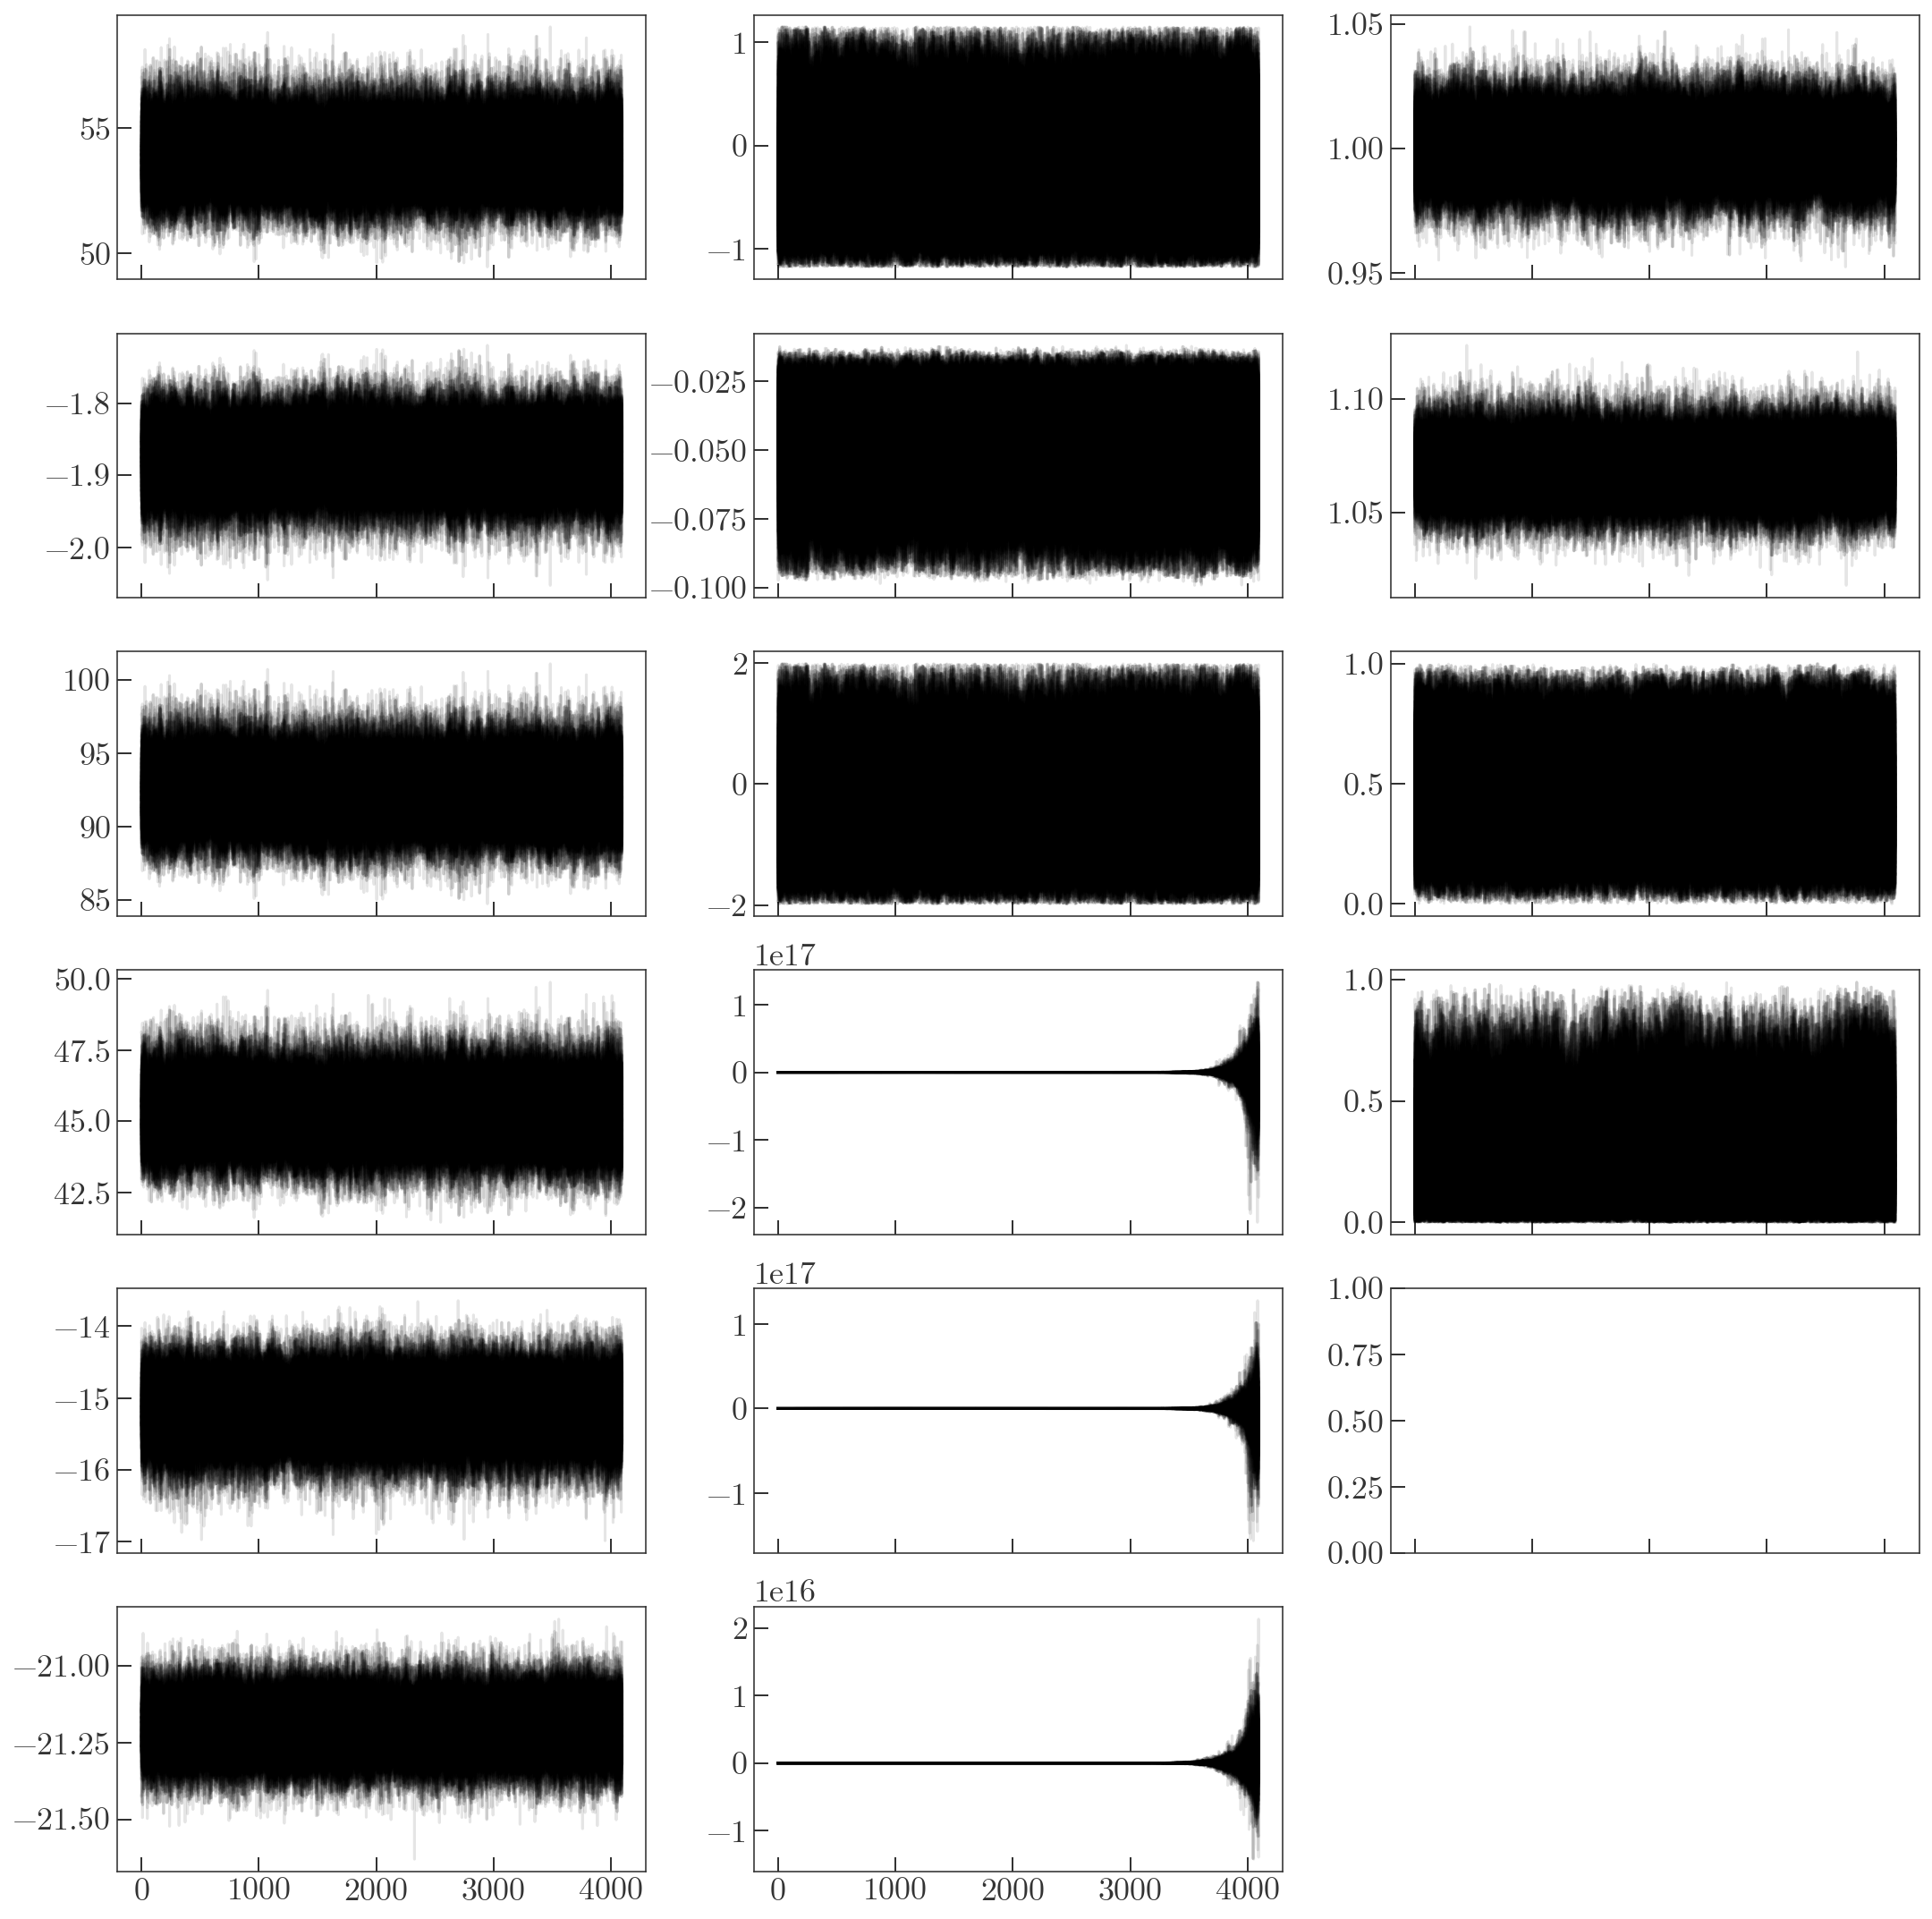

In [61]:
n_plot_walkers = 128
alpha = 0.1

fig,axes = plt.subplots(6, 3, figsize=(15,15), sharex=True)

temp = 0

for k in range(0,6):
    for j in range(n_plot_walkers):
        axes[k,0].plot(pt_sampler.chain[temp,j,:,k], marker='', alpha=alpha, 
                       drawstyle='steps-mid', color='k')
        
for k in range(0,6):
    for j in range(n_plot_walkers):
        axes[k,1].plot(pt_sampler.chain[temp,j,:,k+6], marker='', alpha=alpha, 
                       drawstyle='steps-mid', color='k')
        
for k in range(0,4):
    for j in range(n_plot_walkers):
        axes[k,2].plot(pt_sampler.chain[temp,j,:,k+12], marker='', alpha=alpha, 
                       drawstyle='steps-mid', color='k')

fig.tight_layout()

axes[-1,-1].set_visible(False)

fig.savefig('../plots/trace_pt.png')

In [65]:
flatchain = np.vstack(pt_sampler.chain[0])
flatchain = np.vstack((flatchain.T, 1-(flatchain[:,-2]+flatchain[:,-1]))).T

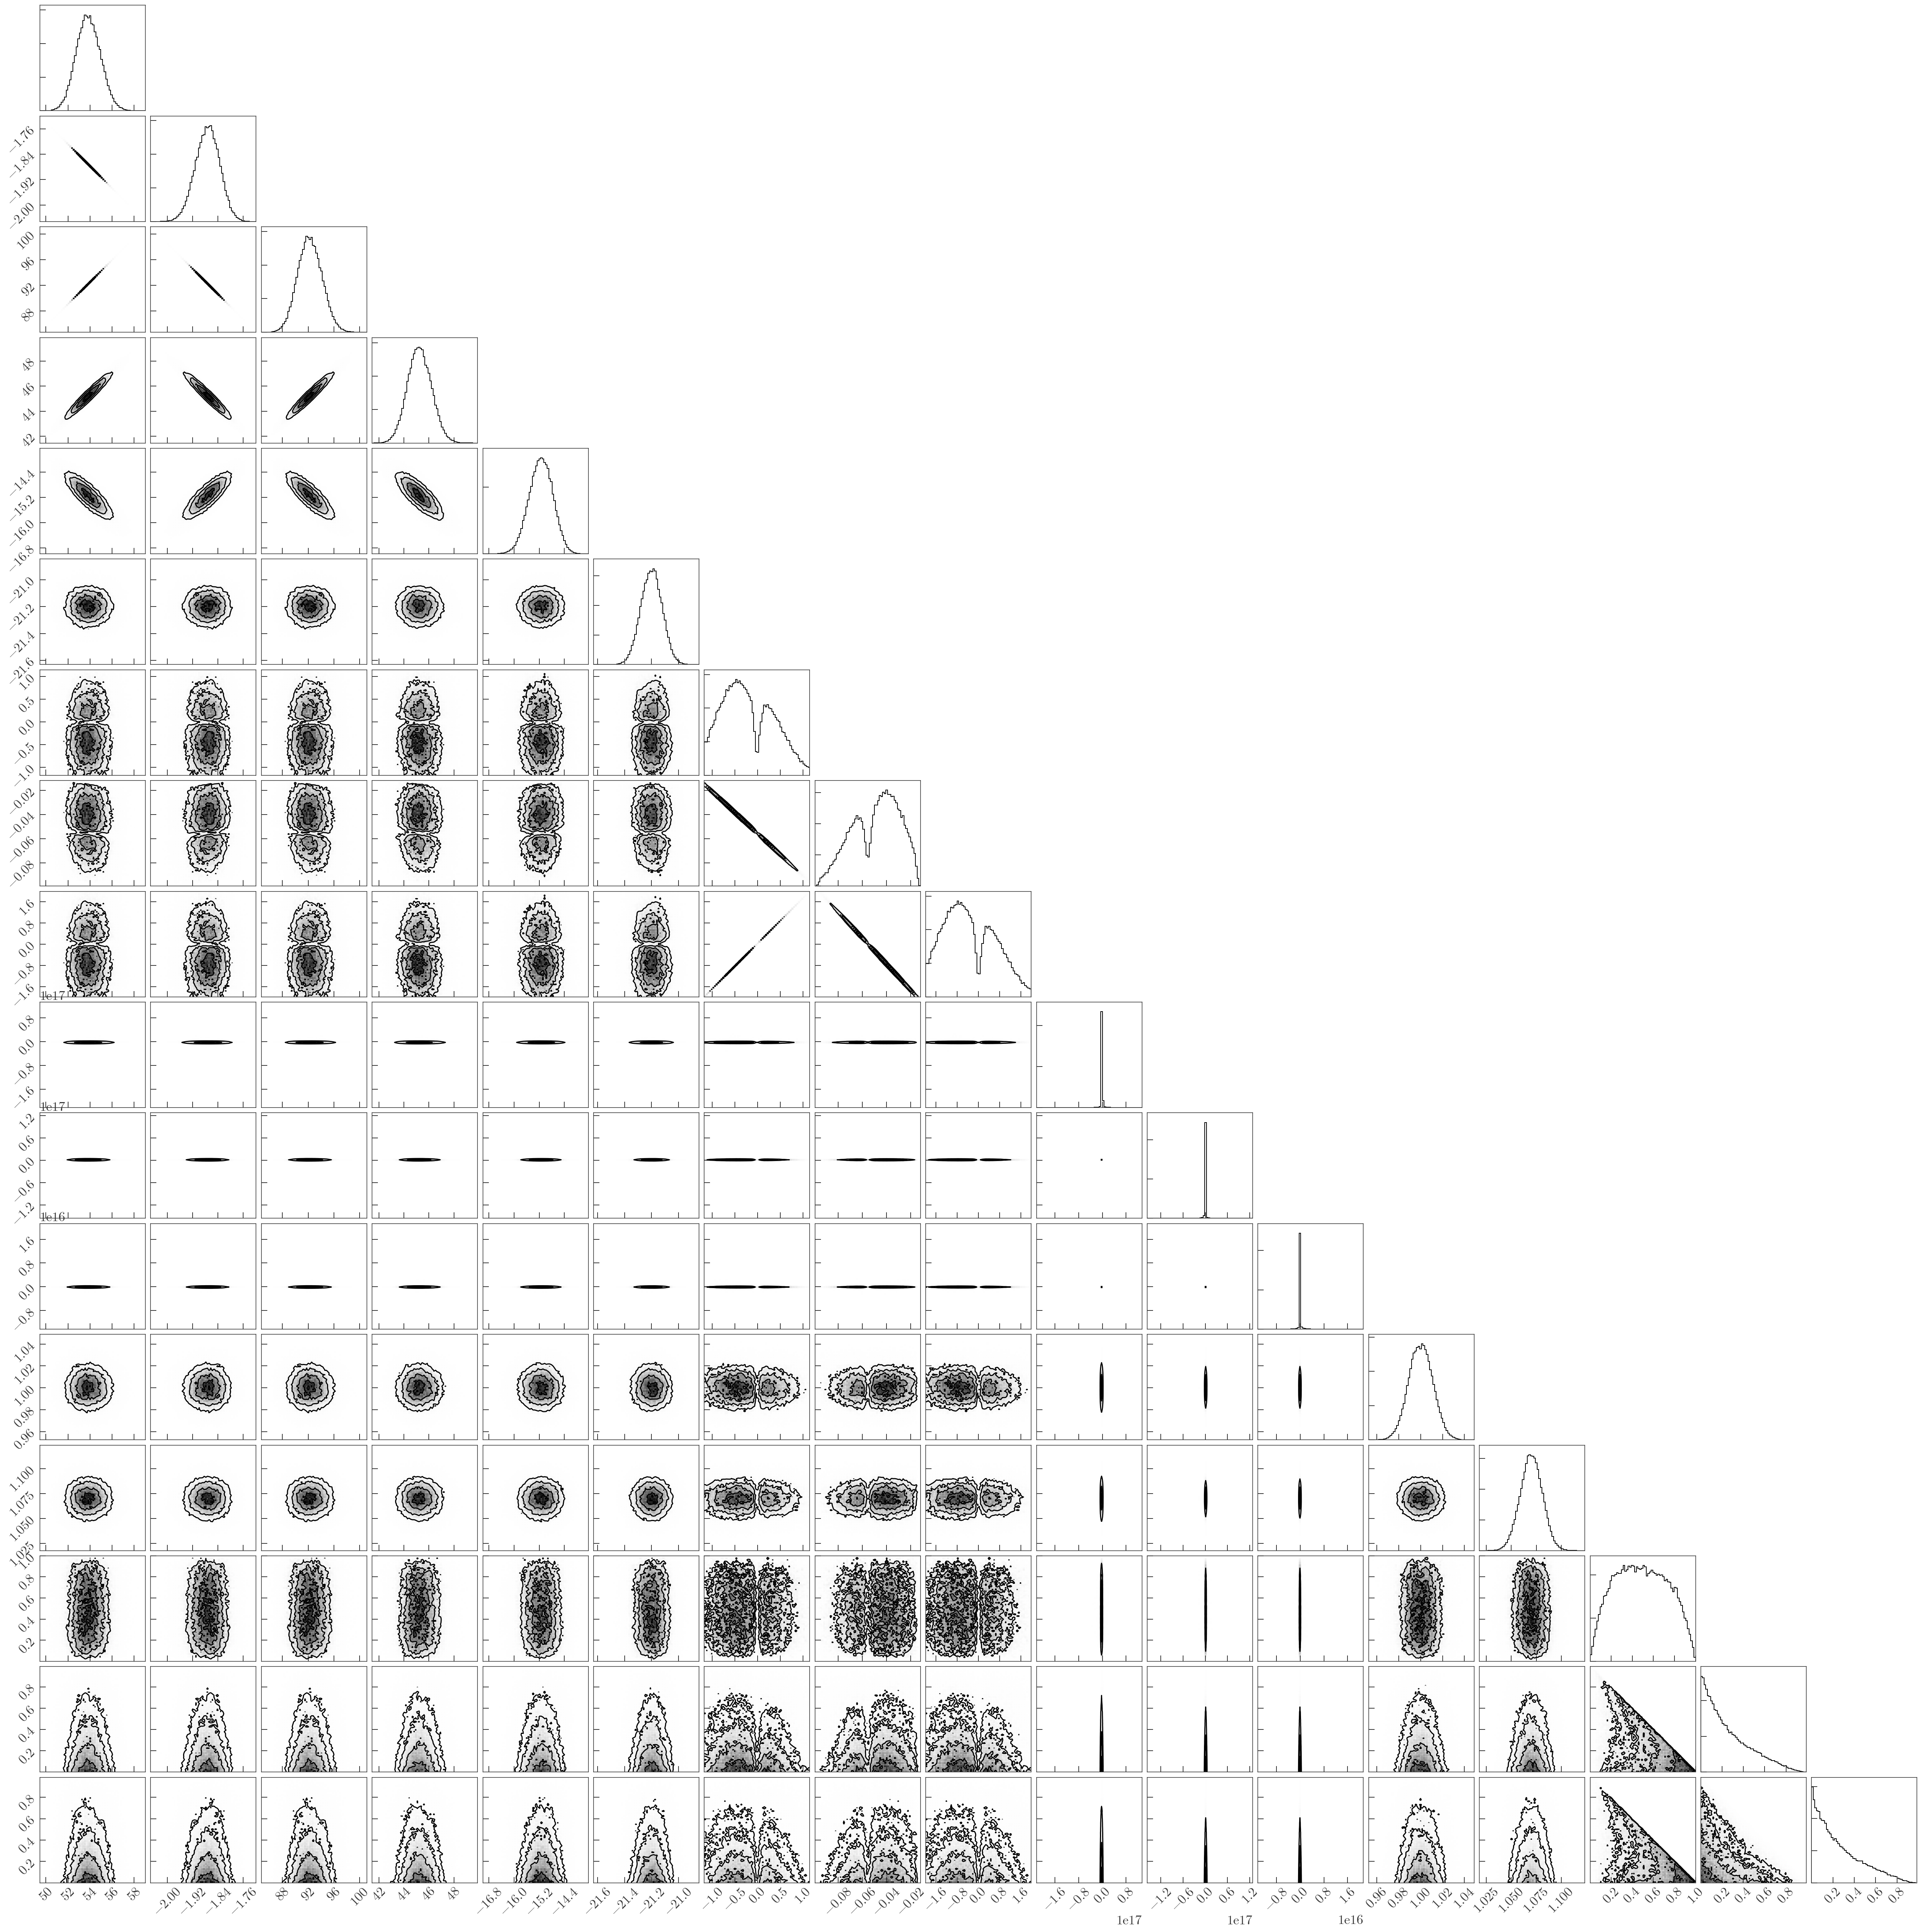

In [66]:
fig = corner.corner(flatchain, bins=64, plot_datapoints=False)
#                     labels=['$r_1$ [pc]', r'$v_{\alpha,1}$ [km/s]', r'$v_{\delta,1}$ [km/s]', '$v_{r,1}$ [km/s]', 
#                             '$r_2$ [pc]', r'$v_{\alpha,2}$ [km/s]', r'$v_{\delta,2}$ [km/s]', '$v_{r,2}$ [km/s]', 
#                             r'$\ln a/{\rm pc}$', '$f_1$ (bound)', '$f_2$ (comoving)', '$f_3$ (field)'])
fig.savefig('../plots/corner.png')
del fig

In [72]:
dx = np.sqrt(np.sum(flatchain[:,6:9]**2, axis=-1))

In [ ]:
# np.save('pt_chain_temp0.npy', pt_sampler.chain[0])

In [ ]:
s = np.random.dirichlet(alpha=[2,1,1], size=100000)
_ = corner.corner(s)